# Final Activity 1

Voughtazon Inc. used to have different stalls which sell action figures of their Top 10 most
popular superhero franchises. Before reopening these stalls, the company would like to analyze
the previous total sales of their products and develop a time series forecast model. The
productsales.csv dataset contains time series data covering the years 2010-2019. The columns
include stall id [0-6, there are 7 stalls in different locations], product type [0-9, there are 10
characters/types of the action figures], date [yyyy-mm-dd], and number sold [number of action
figures sold].

In [126]:
# Import dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

sales = pd.read_csv("data/productsales.csv", parse_dates=['date'])
sales

,stall_id,product_type,date,number_sold
0,0,0,2010-01-01,801
1,0,0,2010-01-02,810
2,0,0,2010-01-03,818
3,0,0,2010-01-04,796
4,0,0,2010-01-05,808
...,...,...,...,...
255635,6,9,2019-12-27,901
255636,6,9,2019-12-28,926
255637,6,9,2019-12-29,913
255638,6,9,2019-12-30,899


## Data Exploration

In [127]:
print("Data Overview:")
print(f"Unique Stalls: {sales['stall_id'].nunique()}")
print(f"Unique Products: {sales['product_type'].nunique()}\n")
sales[["number_sold"]].describe()

Data Overview:
Unique Stalls: 7
Unique Products: 10



,number_sold
count,255640.000000
mean,781.838077
std,204.910291
min,234.000000
25%,722.000000
50%,836.000000
75%,916.000000
max,1205.000000


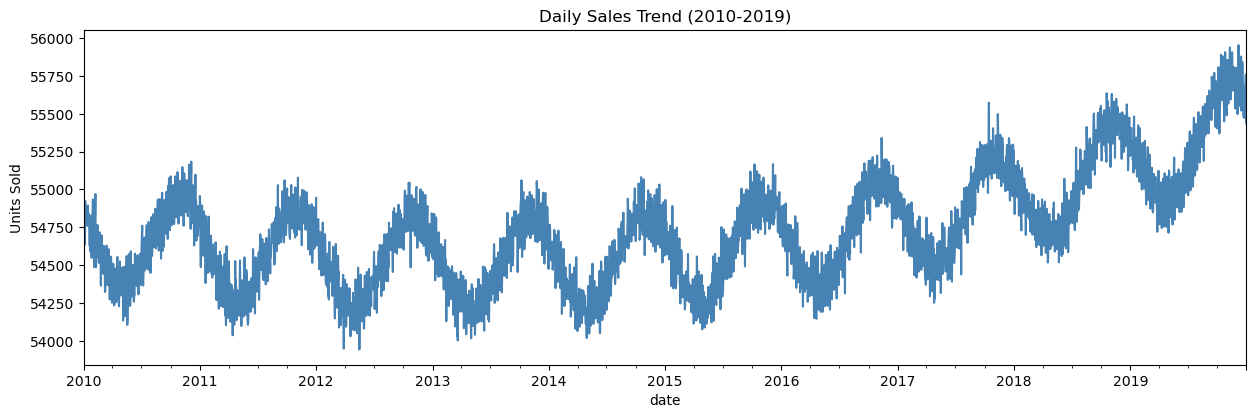

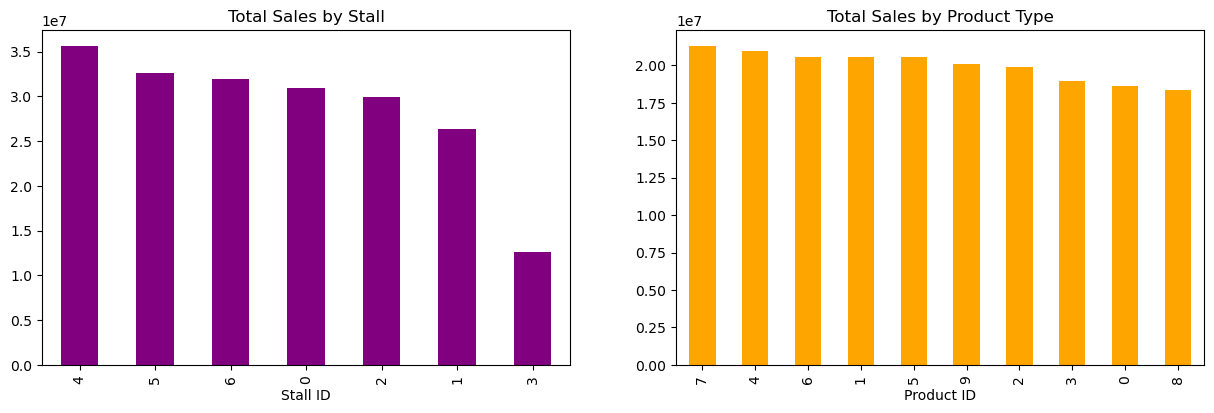

In [128]:
# Daily Sales Trend
plt.figure(figsize=(15, 20))
plt.subplot(4, 1, 1)
daily_sales = sales.groupby('date')['number_sold'].sum()
daily_sales.plot(title='Daily Sales Trend (2010-2019)', color='steelblue')
plt.ylabel('Units Sold')

# Stall performance
plt.figure(figsize=(15, 20))
stall_sales = sales.groupby('stall_id')['number_sold'].sum().sort_values(ascending=False)
plt.subplot(4, 2, 1)
stall_sales.plot(kind='bar', color='purple')
plt.title('Total Sales by Stall')
plt.xlabel('Stall ID')

# Product popularity
product_sales = sales.groupby('product_type')['number_sold'].sum().sort_values(ascending=False)
plt.subplot(4, 2, 2)
product_sales.plot(kind='bar', color='orange')
plt.title('Total Sales by Product Type')
plt.xlabel('Product ID')
plt.show()

## Data Pre-processing

In [129]:
# ADF Test
daily_sales = sales.groupby('date')['number_sold'].sum()
daily_sales = daily_sales.asfreq('D')

def test_stationarity(data):
    adf = adfuller(data, autolag='AIC')
    adf_stat = adf[0]
    p_value = adf[1]
    crit_vals = adf[4]

    print(f'ADF Statistic: {adf_stat:.4f}')
    print(f'p-value: {p_value:.4f}')

    stationary = p_value < 0.05
    print(f'Conclusion: {"Stationary" if stationary else "Non-Stationary"}')

log_sales = np.log1p(daily_sales)
diff_sales = log_sales.diff(7).dropna()

print("Initial ADF Test:")
test_stationarity(daily_sales)
print("\nAfter Transformation:")
test_stationarity(diff_sales)

Initial ADF Test:
ADF Statistic: -2.5001
p-value: 0.1155
Conclusion: Non-Stationary

After Transformation:
ADF Statistic: -5.5492
p-value: 0.0000
Conclusion: Stationary


## Model Training

In [130]:
# Split Data
train = log_sales.loc['2010':'2018']
test = daily_sales.loc['2019']

# Train the model!
model = SARIMAX(train,
                order=(1, 0, 1),
                seasonal_order=(1, 1, 1, 7)
                )
results = model.fit(disp=False)

# Forecasting
forecast = results.get_forecast(steps=len(test))
predicted_sales = np.expm1(forecast.predicted_mean)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       number_sold   No. Observations:                 3287
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood               15808.003
Date:                           Mon, 07 Jul 2025   AIC                         -31606.005
Time:                                   19:56:41   BIC                         -31575.527
Sample:                               01-01-2010   HQIC                        -31595.092
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8004      0.072     11.145      0.000       0.660       0.941
ma.L1         -0.7357      0.083     -8.836      0.000      -0.899      -0.572
ar.S.L7        0.0278      0.031      0.887      0.375      -0.034       0.089
ma.S.L7       -0.6272      0.030    -20.746      0.000      -0.686      -0.568
sigma2      3.792e-06   1.13e-07     33.641      0.000    3.57e-06    4.01e-06
===================================================================================
Ljung-Box (L1) (Q):                 145.70   Jarque-Bera (JB):                 1.31
Prob(Q):                              0.00   Prob(JB):                         0.52
Heteroskedasticity (H):               0.96   Skew:                             0.04
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Evaluation Metrics

In [131]:
# Evaluation
mae = mean_absolute_error(test, predicted_sales)
rmse = np.sqrt(mean_squared_error(test, predicted_sales))
mape = np.mean(np.abs((test - predicted_sales) / test)) * 100

print("Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

Evaluation Metrics:
MAE: 271.23
RMSE: 307.65
MAPE: 0.49%


## Visualization

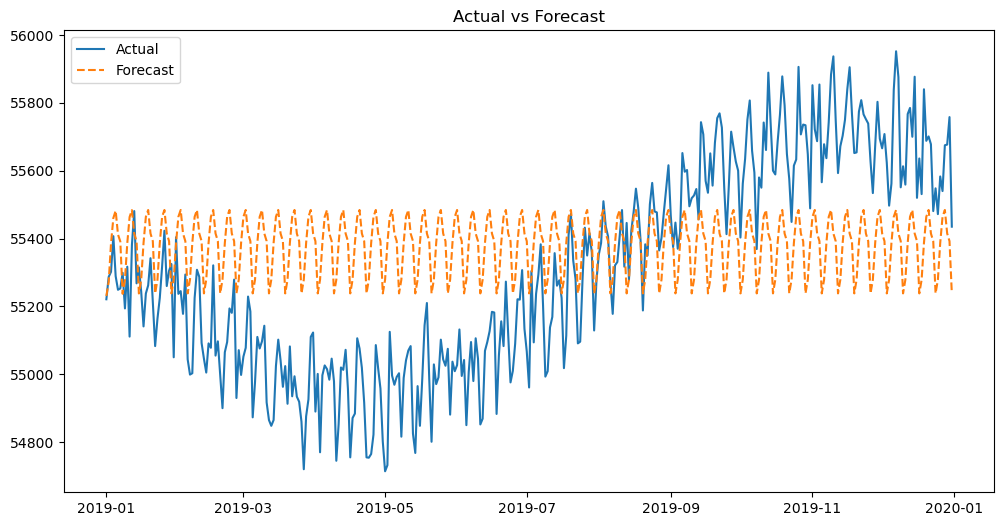

In [132]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predicted_sales, label='Forecast', linestyle='--')
plt.title('Actual vs Forecast')
plt.legend()
plt.show()